In [23]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import os
import random
from scipy.stats import spearmanr
import sys
from tqdm import tqdm

sys.path.insert(0, '../src')
sys.path.insert(0, '..')
from main import get_model
from models.config import Config, IMAGE_TOKEN_IDS
import db_utils, utils, visualizations, similarity_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Obtain paths for non-face TLL image pairs

In [34]:
def filter_images(data_dir,
                  visualize=False,
                  save_dir=None,
                  overwrite=False):
    if save_dir is not None:
        right_save_path = os.path.join(save_dir, "filtered_right_paths.txt")
        left_save_path = os.path.join(save_dir, "filtered_left_paths.txt")
        if os.path.exists(right_save_path) and os.path.exists(left_save_path) and not overwrite:
            utils.informal_log("File exists at {} and {} and not overwriting".format(
                left_save_path, right_save_path))
            return utils.read_file(left_save_path), utils.read_file(left_save_path)

    metadata_path = os.path.join(data_dir, "metadata.pkl")
    metadata = utils.read_file(metadata_path)

    # Map image names from Images/ to right/left names
    paired_image_names = metadata['image_list']
    single_image_names = sorted(os.listdir(os.path.join(data_dir, "right")))
    paired_single_dict = dict(zip(paired_image_names, single_image_names))

    # Get list of image names that are in "no_faces"
    filtered_boolean = metadata['no_faces']
    filtered_paired_image_names = np.array(paired_image_names)[filtered_boolean]
    # Get the corresponding right/left image names
    filtered_single_image_names = [paired_single_dict[paired_name] for paired_name in filtered_paired_image_names]
    assert len(filtered_paired_image_names) == len(filtered_single_image_names)
    if visualize:
        rand_int = random.randint(0, len(filtered_single_image_names) - 1)
        utils.informal_log("Randomly visualizing image {}".format(rand_int))
        visualizations.show_image_rows(
            [[utils.read_file(os.path.join(data_dir, "Images", filtered_paired_image_names[rand_int])),
            utils.read_file(os.path.join(data_dir, "left", filtered_single_image_names[rand_int])),
            utils.read_file(os.path.join(data_dir, "right", filtered_single_image_names[rand_int]))]]
        )

    # Make separate lists for right and left
    left_save_paths = []
    right_save_paths = []
    for filename in filtered_single_image_names:
        left_save_paths.append(os.path.join(data_dir, "left", filename))
        right_save_paths.append(os.path.join(data_dir, "right", filename))
    if save_dir is not None:
        utils.write_file(left_save_paths, left_save_path, overwrite=overwrite)
        utils.write_file(right_save_paths, right_save_path, overwrite=overwrite)

    return left_save_paths, right_save_paths


In [35]:
data_dir = "../data_local/tll/totally_looks_like"
save_dir = "../data_local/tll"

image_names = filter_images(
    data_dir=data_dir,
    visualize=True,
    save_dir=save_dir,
    overwrite=False)

[1027_094803] File exists at ../data_local/tll/filtered_left_paths.txt and ../data_local/tll/filtered_right_paths.txt and not overwriting


## Run Model on Left and Right Images

### Left Images

In [2]:
sys.argv = ['notebooks/get_representations.ipynb',
            '--config', '../configs/models/qwen/Qwen2-VL-7B-Instruct-TLL-Left.yaml']

config = Config()

In [ ]:
model = get_model(config.architecture, config)


n_modules = 0
layer_names = []
for name, module in model.model.named_modules():
    if model.config.matches_module(name):
        print(name)
        layer_names.append(name)
        n_modules += 1
utils.informal_log("{} modules matched".format(n_modules))
left_db_path = model.config.output_db

Loading checkpoint shards: 100%|██████████| 5/5 [00:00<00:00, 23.62it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


visual.blocks.31
visual.merger
model.layers.27
model.norm
[1028_081636] 4 modules matched


In [ ]:
# Run model -- first checking if we would overwrite anything

utils.informal_log("Database path: {}".format(left_db_path))
proceed = True
if os.path.exists(left_db_path):
    response = input("File exists at {}. Are you sure you want to overwrite? (Y/N)".format(left_db_path))
    if response.lower() != "y":
        proceed = False
    else:
        os.remove(left_db_path)

if proceed:
    # Run model on images
    model.run(save_tokens=True)
else:
    utils.informal_log("Not overwriting file at {}".format(left_db_path))

[1028_081638] Database path: ../output/TLL/Qwen2-VL-7B-Instruct/TLL-Left.db


[1028_081639] Not overwriting file at ../output/TLL/Qwen2-VL-7B-Instruct/TLL-Left.db


### Right Images

In [5]:
sys.argv = ['notebooks/get_representations.ipynb',
            '--config', '../configs/models/qwen/Qwen2-VL-7B-Instruct-TLL-Right.yaml']

config = Config()

In [8]:
model = get_model(config.architecture, config)


n_modules = 0
layer_names = []
for name, module in model.model.named_modules():
    if model.config.matches_module(name):
        print(name)
        layer_names.append(name)
        n_modules += 1
utils.informal_log("{} modules matched".format(n_modules))
right_db_path = model.config.output_db

Loading checkpoint shards: 100%|██████████| 5/5 [00:00<00:00, 32.08it/s]


visual.blocks.31
visual.merger
model.layers.27
model.norm
[1028_081704] 4 modules matched


In [9]:
# Run model -- first checking if we would overwrite anything

utils.informal_log("Database path: {}".format(right_db_path))
proceed = True
if os.path.exists(right_db_path):
    response = input("File exists at {}. Are you sure you want to overwrite? (Y/N)".format(right_db_path))
    if response.lower() != "y":
        proceed = False
    else:
        os.remove(right_db_path)

if proceed:
    # Run model on images
    model.run(save_tokens=True)
else:
    utils.informal_log("Not overwriting file at {}".format(right_db_path))

[1028_081705] Database path: ../output/TLL/Qwen2-VL-7B-Instruct/TLL-Right.db


[1028_081706] Not overwriting file at ../output/TLL/Qwen2-VL-7B-Instruct/TLL-Right.db


## To save .db embeddings as separate .npy files per layer:

Run `conda activate vlm-lens-base && cd notebooks && python tll.py`.

TODO: Need to update file to do both R and L

## Get Embeddings and Compute Similarities

In [11]:
modality = "vision"
left_db_dir = os.path.splitext(left_db_path)[0]
right_db_dir = os.path.splitext(right_db_path)[0]

left_input_ids, left_input_ids_same_shapes = similarity_utils.get_embedding(
    database_path=left_db_dir,
    layer_name="input_ids"
)

right_input_ids, right_input_ids_same_shapes = similarity_utils.get_embedding(
    database_path=right_db_dir,
    layer_name="input_ids"
)

similarity_save_dir = os.path.join(os.path.dirname(left_db_dir), "similarities")
utils.ensure_dir(similarity_save_dir)
overwrite = False

for layer_name in tqdm(layer_names):
    save_path = os.path.join(similarity_save_dir, "sim-{}.npy".format(layer_name))
    if os.path.exists(save_path) and not overwrite:
        utils.informal_log("File exists at {} and not overwriting".format(save_path))
        continue

    layer_modality = model.get_layer_modality(layer_name)

    # Get embeddings from .npy files
    left_embedding, left_same_shapes = similarity_utils.get_embedding(
        database_path=left_db_dir,
        layer_name=layer_name
    )

    right_embedding, right_same_shapes = similarity_utils.get_embedding(
        database_path=right_db_dir,
        layer_name=layer_name
    )

    # Extract vision tokens of embedding
    left_modality_name, left_modality_embedding, left_n_embeddings = similarity_utils.extract_modality(
        layer_modality=layer_modality,
        modality=modality,
        module_embedding=left_embedding,
        module_name=layer_name,
        image_token_id=IMAGE_TOKEN_IDS[model.config.architecture],
        input_ids=left_input_ids,
        module_embedding_same_shapes=left_same_shapes
    )

    right_modality_name, right_modality_embedding, right_n_embeddings = similarity_utils.extract_modality(
        layer_modality=layer_modality,
        modality=modality,
        module_embedding=right_embedding,
        module_name=layer_name,
        image_token_id=IMAGE_TOKEN_IDS[model.config.architecture],
        input_ids=right_input_ids,
        module_embedding_same_shapes=right_same_shapes)

    # Calculate mean embedding
    left_mean_embeddings = db_utils.compute_mean_embeddings(
        embeddings=left_modality_embedding,
        n_embeddings=left_n_embeddings)

    right_mean_embeddings = db_utils.compute_mean_embeddings(
        embeddings=right_modality_embedding,
        n_embeddings=right_n_embeddings)

    # Calculate similarity
    similarities = db_utils.cosine_similarity_numpy(
        left_mean_embeddings,
        right_mean_embeddings,
        elementwise=True)


    print(layer_name, np.mean(similarities))
    # Write to file
    utils.write_file(similarities, save_path, overwrite=overwrite)


  0%|          | 0/4 [00:00<?, ?it/s]

[1028_081750] File exists at ../output/TLL/Qwen2-VL-7B-Instruct/similarities/sim-visual.blocks.31.npy and not overwriting
[1028_081750] File exists at ../output/TLL/Qwen2-VL-7B-Instruct/similarities/sim-visual.merger.npy and not overwriting
(1622, 170, 3584) (1622, 170, 3584)


 75%|███████▌  | 3/4 [00:10<00:03,  3.55s/it]

model.layers.27 0.8607614674799318
Saved file to ../output/TLL/Qwen2-VL-7B-Instruct/similarities/sim-model.layers.27.npy
(1622, 170, 3584) (1622, 170, 3584)


100%|██████████| 4/4 [01:45<00:00, 26.28s/it]

model.norm 0.7079958200880941
Saved file to ../output/TLL/Qwen2-VL-7B-Instruct/similarities/sim-model.norm.npy


#### Visualize distribution of similarities at each layer

/n/fs/ac-vlm/vlm-lens/notebooks/../src/visualizations.py:828: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


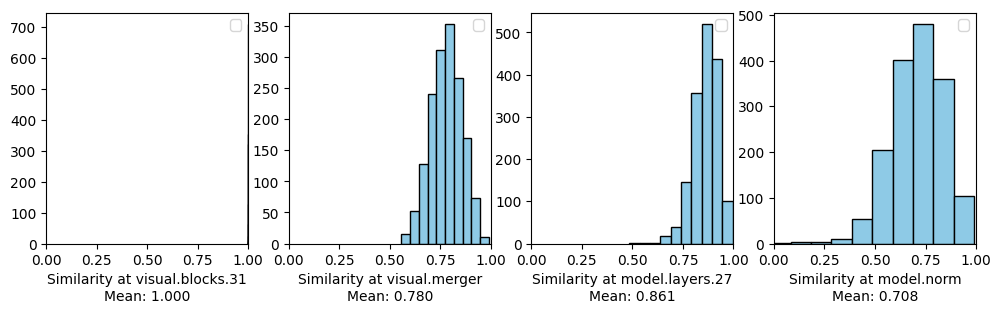

In [ ]:
all_similarities = {}
fig, axes = plt.subplots(nrows=1, ncols=len(layer_names), figsize=(12, 3))
for idx, layer_name in enumerate(layer_names):
    load_path = os.path.join(similarity_save_dir, "sim-{}.npy".format(layer_name))
    similarities = utils.read_file(load_path)
    all_similarities[layer_name] = similarities
    fig, axes[idx], _ = visualizations.histogram(
        similarities,
        xlabel="Similarity at {}\nMean: {:.3f}".format(layer_name, np.mean(similarities)),
        xlim=[0, 1.0],
        fig=fig,
        ax=axes[idx],
        show=False)

plt.show()

#### Calculate correlations between each pair of visual -> text representations

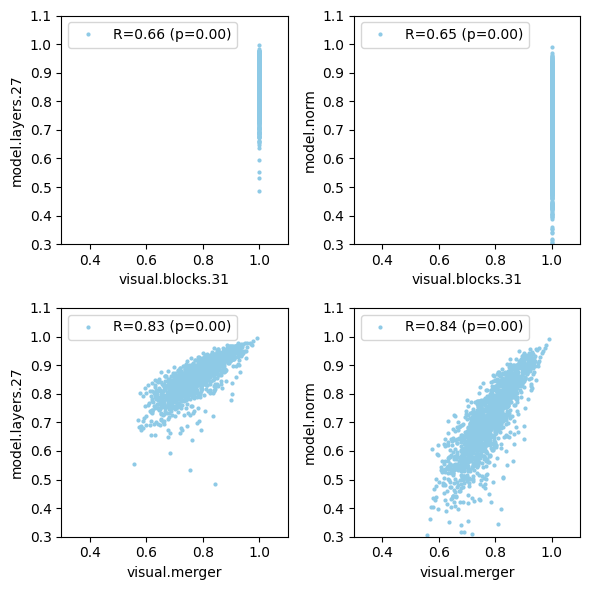

In [24]:
visual_layer_names = []
text_layer_names = []
for layer_name in layer_names:
    if layer_name.startswith(model.get_vision_key()):
        visual_layer_names.append(layer_name)
    else:
        text_layer_names.append(layer_name)

n_rows = len(visual_layer_names)
n_cols = len(text_layer_names)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3 * n_rows, 3 * n_cols))

for row_idx, v_layer in enumerate(visual_layer_names):
    for col_idx, t_layer in enumerate(text_layer_names):
        v_similarities = all_similarities[v_layer]
        t_similarities = all_similarities[t_layer]
        corr, pval = spearmanr(v_similarities, t_similarities)

        fig, axes[row_idx, col_idx] = visualizations.plot(
            fig=fig,
            ax=axes[row_idx, col_idx],
            xs=[v_similarities],
            ys=[t_similarities],
            line=False,
            marker_size=2,
            xlabel=v_layer,
            ylabel=t_layer,
            xlimits=[0.3, 1.1],
            ylimits=[0.3, 1.1],
            labels=['R={:.2f} (p={:.2f})'.format(corr, pval)]
        )

#### Visualize top and bottom similar images at each layer

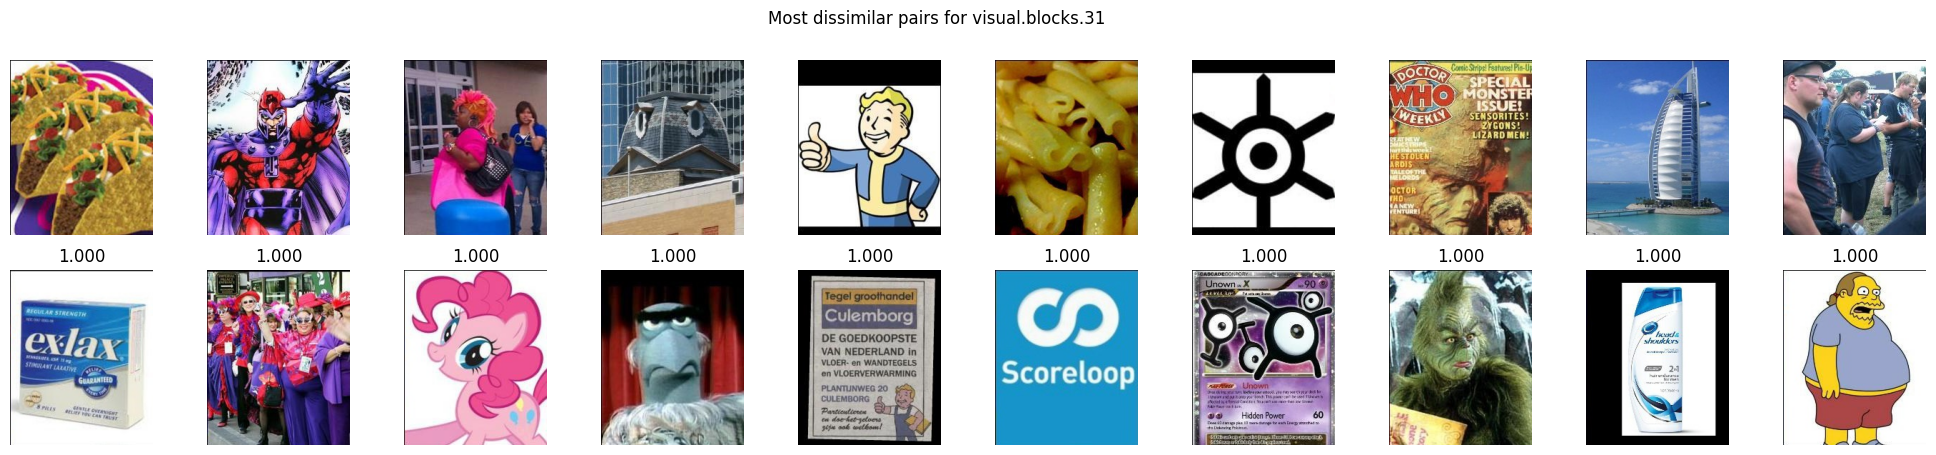

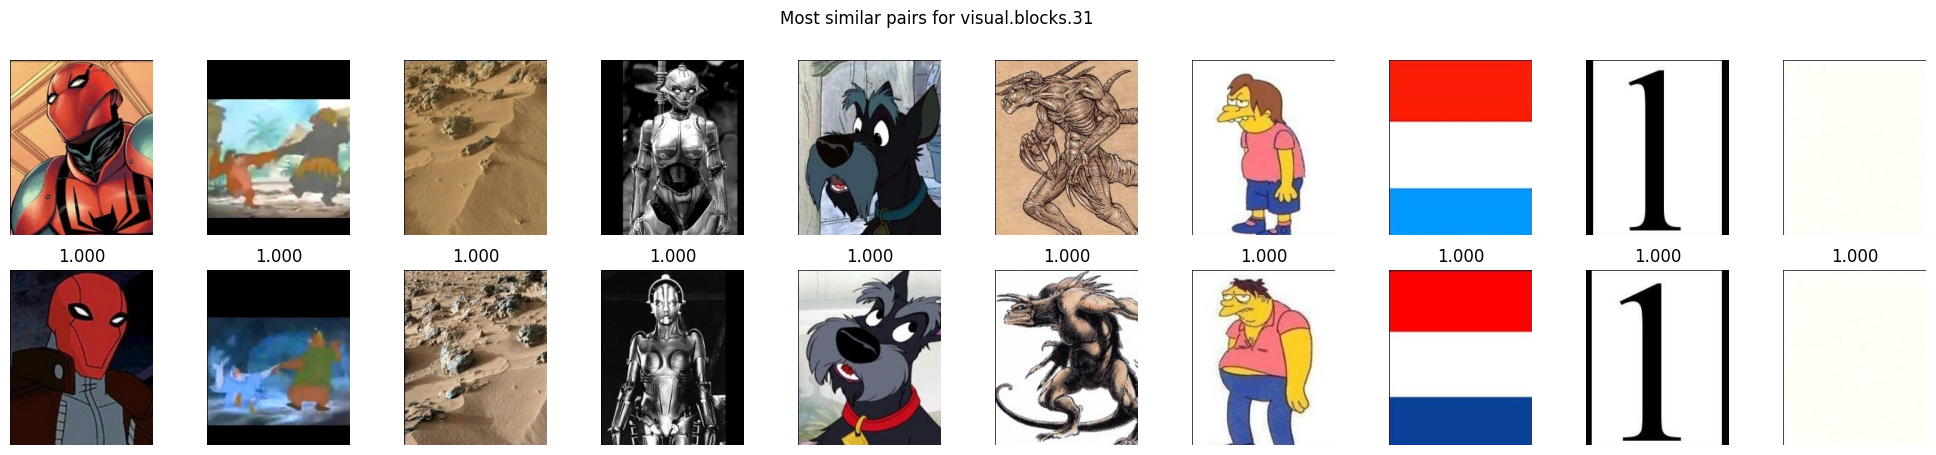

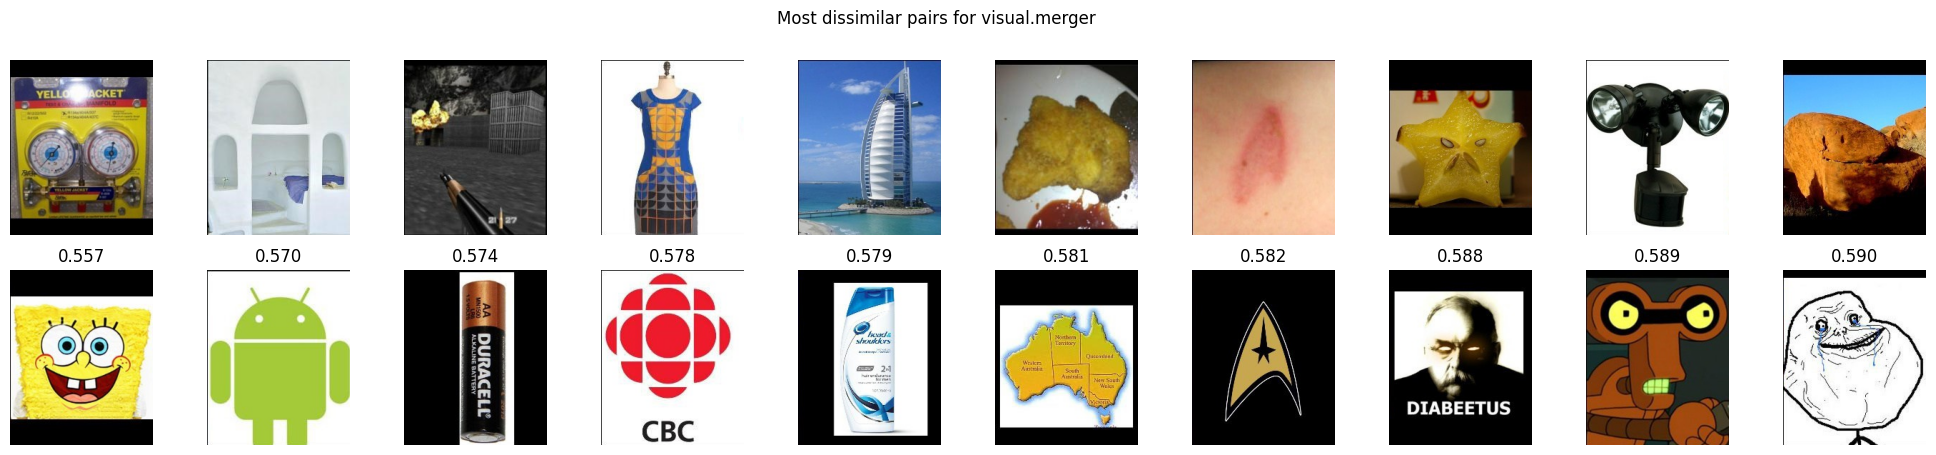

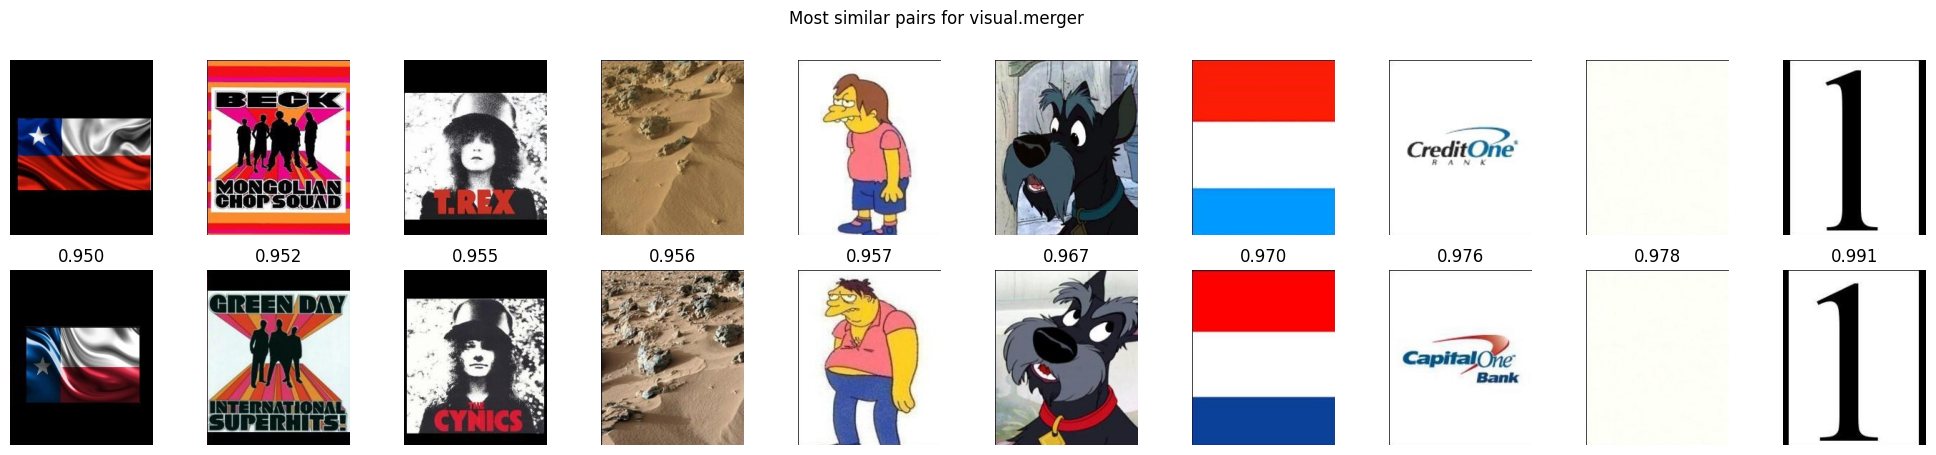

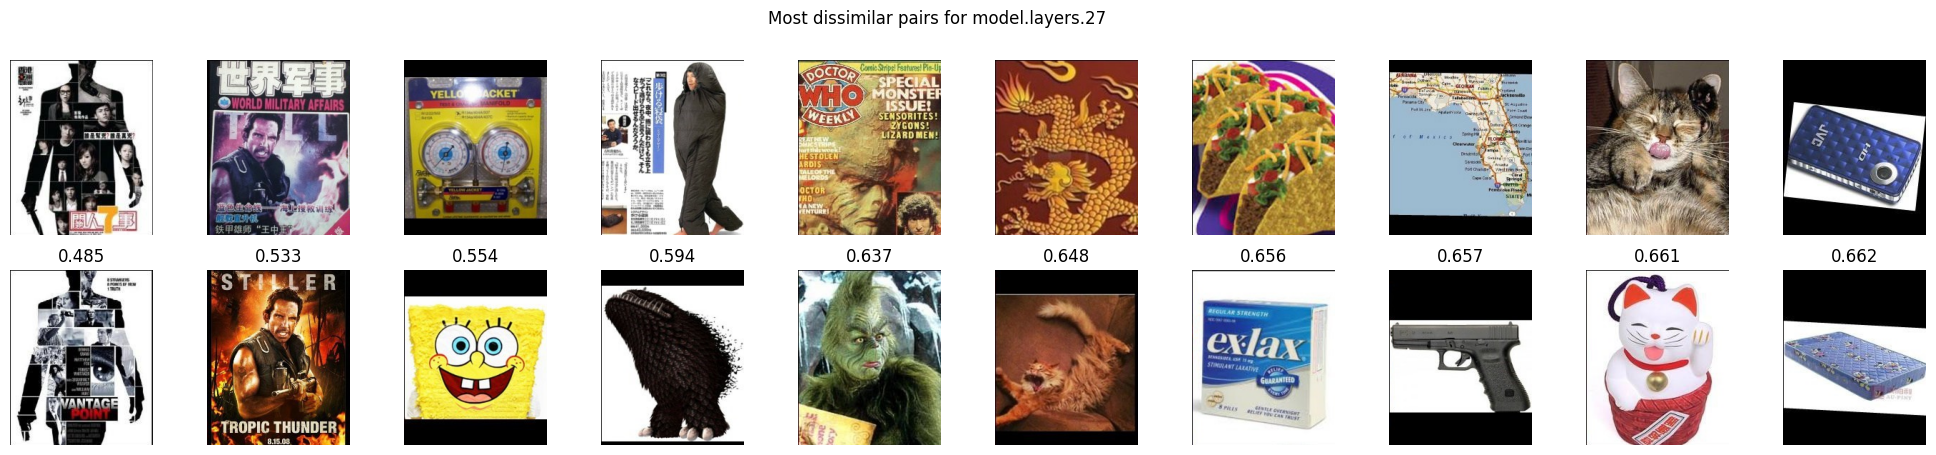

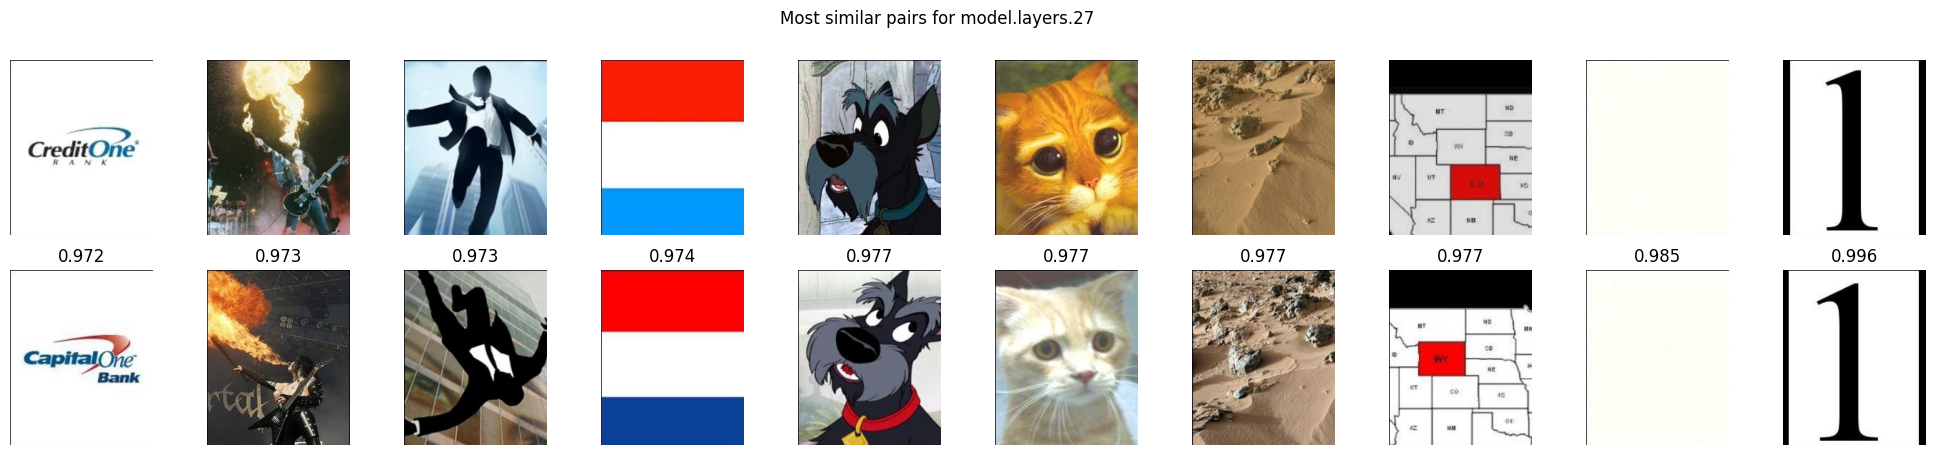

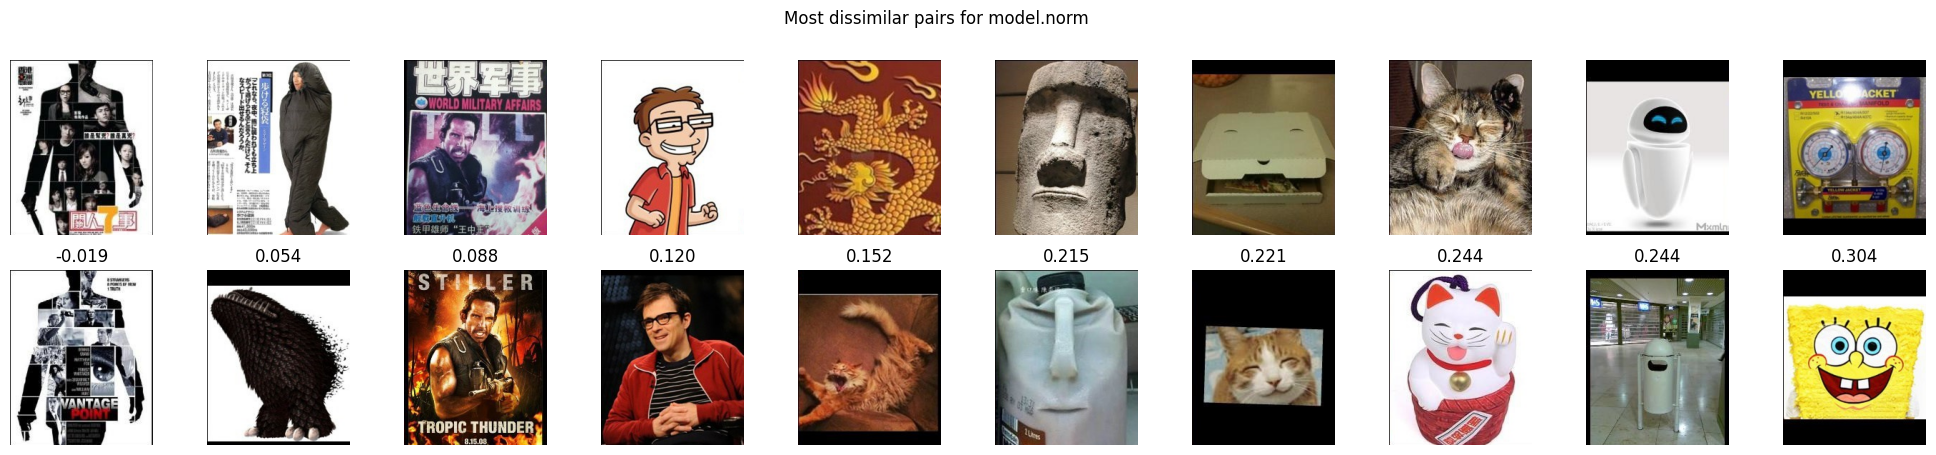

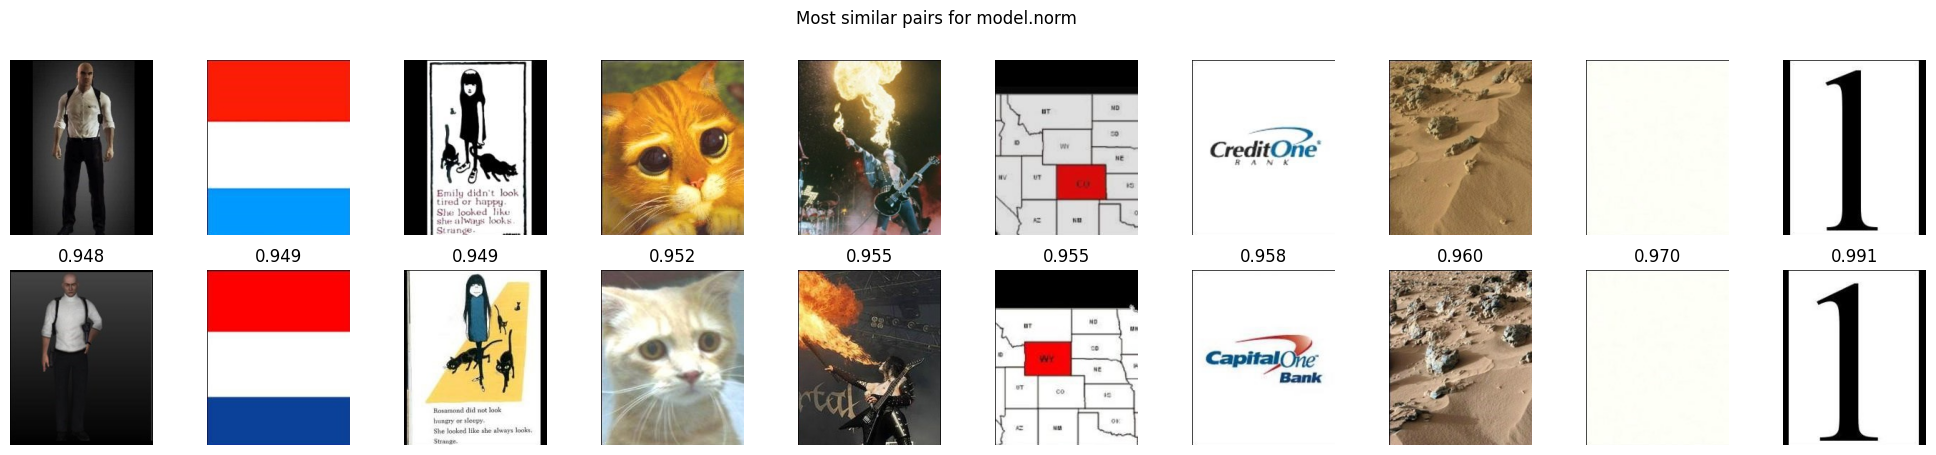

In [ ]:
n_display = 10
filenames = utils.read_file("../data_local/tll/filtered_singles_filenames.txt")
left_data_dir = "../data_local/tll/totally_looks_like/left"
right_data_dir = "../data_local/tll/totally_looks_like/right"

def plot_pairs(filenames,
               left_data_dir,
               right_data_dir,
               similarities,
               layer_name,
               most="dissimilar"):
    left_images = []
    right_images = []
    for filename in filenames:
        left_path = os.path.join(left_data_dir, filename)
        right_path = os.path.join(right_data_dir, filename)
        left_images.append(utils.read_file(left_path))
        right_images.append(utils.read_file(right_path))

    visualizations.show_image_rows(
        images=[left_images, right_images],
        image_titles=[["" for _ in similarities], ["{:.3f}".format(sim) for sim in similarities]],
        figure_title="Most {} pairs for {}".format(most, layer_name)
    )

for layer_name in layer_names:
    similarities = all_similarities[layer_name]
    sort_idxs = np.argsort(similarities) # Sort low to high

    dissimilar_idxs = sort_idxs[:n_display]
    dissimilar_filenames = np.array(filenames)[dissimilar_idxs]
    top_dissimilarities = similarities[dissimilar_idxs]

    plot_pairs(
        similarities=top_dissimilarities,
        left_data_dir=left_data_dir,
        right_data_dir=right_data_dir,
        filenames=dissimilar_filenames,
        layer_name=layer_name,
        most="dissimilar"
    )

    similar_idxs = sort_idxs[-n_display:]
    similar_filenames = np.array(filenames)[similar_idxs]
    top_similarities = similarities[similar_idxs]

    plot_pairs(
        similarities=top_similarities,
        left_data_dir=left_data_dir,
        right_data_dir=right_data_dir,
        filenames=similar_filenames,
        layer_name=layer_name,
        most="similar"
    )


In [11]:
print(left_embeddings[2][:5])

('visual.merger', array([[-2.6250000e+00, -1.9628906e-01,  7.3828125e-01, ...,
         1.7031250e+00,  6.3750000e+00,  2.1972656e-02],
       [-1.5703125e+00, -2.0000000e+00,  2.2187500e+00, ...,
         8.9843750e-01,  4.7187500e+00,  4.3164062e-01],
       [ 8.1640625e-01,  1.3515625e+00,  1.6171875e+00, ...,
        -6.0156250e-01,  5.3515625e-01,  9.0625000e-01],
       ...,
       [ 6.9531250e-01,  3.6773682e-03, -2.9101562e-01, ...,
         2.5000000e-01,  2.8710938e-01, -1.4941406e-01],
       [-1.1669922e-01, -8.3984375e-01,  3.1640625e-01, ...,
         6.3671875e-01,  7.2265625e-01, -2.3437500e-01],
       [-3.5156250e+00, -6.6015625e-01, -4.0625000e-01, ...,
         6.6406250e-01, -1.2265625e+00, -1.9453125e+00]], dtype=float32), None)
